In [2]:
import pandas as pd
import numpy as np
import mlflow
import io
from autogluon.tabular import TabularPredictor, TabularDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from utils.eval import (
    plot_confusion_matrix,
    display_confusion_matrices,
    print_metrics,
    create_and_log_roc_curves,
    find_best_threshold
)

In [3]:
mlflow.set_tracking_uri("file:///C:/Users/Galyna/Documents/_______Machine%20Learning%20Course%202.0/_MidtermProject/mlruns")
print(mlflow.get_tracking_uri())

file:///C:/Users/Galyna/Documents/_______Machine%20Learning%20Course%202.0/_MidtermProject/mlruns


In [4]:
df = pd.read_csv("data/preprocessed_bank_data.csv")

In [5]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['y'])

In [6]:
mlflow.set_experiment("MidTerm Project Autogluon")

with mlflow.start_run(run_name="AutoGluon_Ensemble"):

    # Log model config and training setup
    mlflow.log_params({
        "preset": "good_quality_faster_inference_only_refit",
        "time_limit": 1200,
        "num_bag_folds": 10,
        "num_stack_levels": 0,
        "holdout_frac": 0.4,
        "use_bag_holdout": True,
        "refit_full": False,
        "eval_metric": "f1"
    })
    
    predictor_path = "models/my_predictor"

    predictor = TabularPredictor(
        label='y',
        path=predictor_path,         
        eval_metric='f1'
        ).fit(
        train_data=train_df,
        tuning_data=val_df, 
        use_bag_holdout=True,
        presets='good_quality_faster_inference_only_refit',
        time_limit=1200,
        num_bag_folds=10,
        num_stack_levels=0,
        hyperparameters={
            'RF': {'criterion': 'entropy', 'max_depth': 8},
            'XT': {'max_depth': 8},
            'CAT': {},
            'GBM': {'extra_trees': True}
        }
    )  

    #'Evaluate and log metrics
    for metric, score in predictor.evaluate(val_df).items():
        mlflow.log_metric(f"val_{metric}", score)

    for metric, score in predictor.evaluate(train_df).items():
        mlflow.log_metric(f"train_{metric}", score)

    # Save and log model artifacts
    model_output_dir = predictor.path
    mlflow.log_artifacts(model_output_dir, artifact_path="autogluon_model")

    train_perf = predictor.leaderboard(train_df, silent=True)
    val_perf = predictor.leaderboard(val_df, silent=True)

    train_csv = io.StringIO()
    val_csv = io.StringIO()

    train_perf.to_csv(train_csv, index=False)
    val_perf.to_csv(val_csv, index=False)

    # Rewind the buffers
    train_csv.seek(0)
    val_csv.seek(0)

    # Log as text artifacts to MLflow
    mlflow.log_text(train_csv.getvalue(), artifact_file="train_leaderboard.csv")
    mlflow.log_text(val_csv.getvalue(), artifact_file="val_leaderboard.csv")

Preset alias specified: 'good_quality_faster_inference_only_refit' maps to 'good_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.10 GB / 15.35 GB (20.2%)
Disk Space Avail:   60.95 GB / 470.27 GB (13.0%)
Presets specified: ['good_quality_faster_inference_only_refit']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=10, num_bag_sets=1
Preset alias specified: 'good_quality_faster_inference_only_refit' maps to 'good_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Windows
Platform Machine:   AMD64
P

In [7]:
predictor.leaderboard(val_df, extra_info=True).sort_values("score_val", ascending=False).head()

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,num_features,num_models,num_models_w_ancestors,memory_size,memory_size_w_ancestors,memory_size_min,memory_size_min_w_ancestors,num_ancestors,num_descendants,model_type,child_model_type,stopping_metric,hyperparameters,hyperparameters_fit,ag_args_fit,features,compile_time,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
4,WeightedEnsemble_L2,0.527984,0.358140,f1,0.330126,0.817936,230.168219,0.000000,0.004432,0.235748,2,True,5,2,1,21,3388,16233109,3388,2199813,2,0,WeightedEnsembleModel,GreedyWeightedEnsembleModel,f1,"{'use_orig_features': False, 'valid_stacker': ...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[CatBoost_BAG_L1, LightGBM_BAG_L1]",None,"{'ensemble_size': 25, 'subsample_size': 1000000}",{'ensemble_size': 8},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[CatBoost_BAG_L1, LightGBM_BAG_L1]",[]
7,LightGBM_BAG_L1,0.522128,0.357862,f1,0.231994,0.520004,4.982279,0.231994,0.520004,4.982279,1,True,1,21,10,10,8373625,8373625,1409484,1409484,0,1,StackerEnsembleModel,LGBModel,f1,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[marital, log_age, pdays, poutcome, job, conta...",None,"{'learning_rate': 0.05, 'extra_trees': True}",{'num_boost_round': 255},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],[WeightedEnsemble_L2]
5,CatBoost_BAG_L1,0.524767,0.346307,f1,0.098132,0.293501,224.950192,0.098132,0.293501,224.950192,1,True,3,21,10,10,7856096,7856096,2199813,2199813,0,1,StackerEnsembleModel,CatBoostModel,f1,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[marital, log_age, pdays, poutcome, job, conta...",None,"{'iterations': 10000, 'learning_rate': 0.05, '...",{'iterations': 408},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],[WeightedEnsemble_L2]
6,RandomForest_BAG_L1,0.522196,0.324633,f1,0.102797,0.097089,0.973816,0.102797,0.097089,0.973816,1,True,2,21,1,1,8164611,8164611,8164611,8164611,0,0,StackerEnsembleModel,RFModel,f1,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[marital, log_age, pdays, poutcome, job, conta...",None,"{'n_estimators': 300, 'max_leaf_nodes': 15000,...",{'n_estimators': 300},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],[]
9,ExtraTrees_BAG_L1,0.501241,0.284497,f1,0.084203,0.098903,0.950647,0.084203,0.098903,0.950647,1,True,4,21,1,1,8304630,8304630,8304630,8304630,0,0,StackerEnsembleModel,XTModel,f1,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[marital, log_age, pdays, poutcome, job, conta...",None,"{'n_estimators': 300, 'max_leaf_nodes': 15000,...",{'n_estimators': 300},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],[]


In [8]:
best_model = predictor.model_best

In [9]:
print(best_model)

WeightedEnsemble_L2_FULL


In [10]:
predictor.evaluate(val_df, auxiliary_metrics=True)

{'f1': 0.5534838076545633,
 'accuracy': 0.8895094706168043,
 'balanced_accuracy': 0.7665229885057472,
 'mcc': 0.493575426029854,
 'roc_auc': 0.8676856698139026,
 'precision': 0.5081081081081081,
 'recall': 0.6077586206896551}

In [11]:
train_pred = predictor.predict(train_df)
val_pred   = predictor.predict(val_df)
train_proba = predictor.predict_proba(train_df)
val_proba   = predictor.predict_proba(val_df)
train_targets = train_df['y'].copy()
val_targets   = val_df['y'].copy()

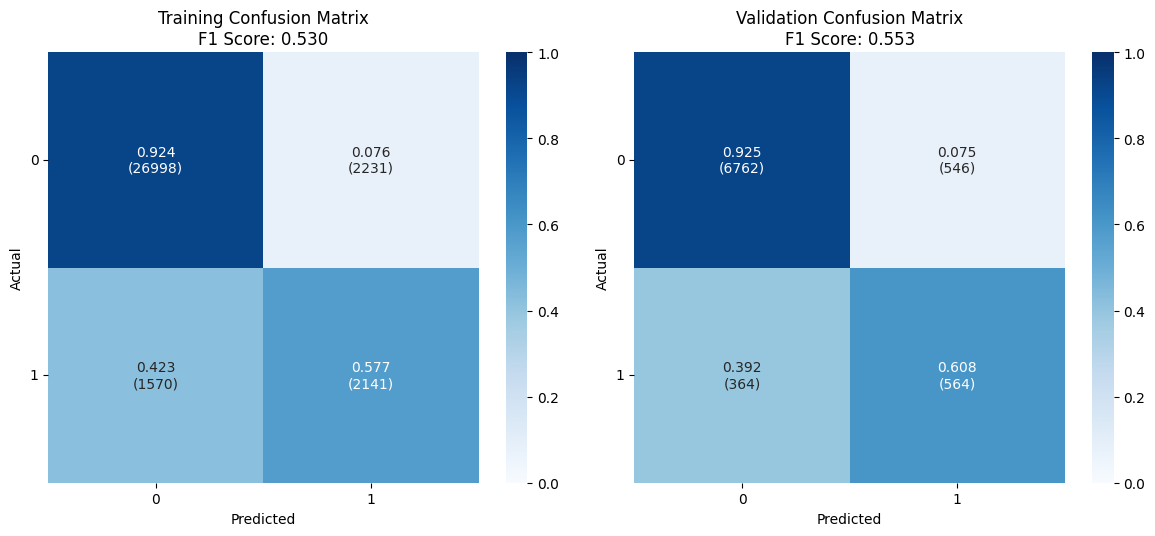

In [12]:
display_confusion_matrices(
    train_targets, train_pred,
    val_targets,   val_pred,
    cmap="Blues"
)

In [17]:
train_proba = train_proba.iloc[:, 1]
val_proba = val_proba.iloc[:, 1]

In [18]:
best_thresh, best_f1 = find_best_threshold(val_targets, val_proba, metric=f1_score)
print("Best threshhold on the validation dataset:", best_thresh)
print("Best F1 score:", best_f1)

Best threshhold on the validation dataset: 0.31
Best F1 score: 0.5650759219088937


#### The model is still not so good at distinguishing class 1, but it's so far the best model we've got. 